The approach here is an SBI-based inference of the parameters from the photometry.  The assumption is that [spectrophotometry.ipynb](spectrophotometry.ipynb) has been run and the corresponding ecsv file exists and has the right filters.

In [1]:
import numpy as np

from astropy import table

from astropy import units as u

from matplotlib import pyplot as plt

import torch

from sbi.inference import NPE
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.analysis import pairplot

In [2]:
t = table.Table.read('spectrophotometry.ecsv')

teff = []
logg = []
feh = []
for row in t:
    n = row['specname']
    teff.append(float(n[3:8]))
    logg.append(float(n[9:13]))
    feh.append(float(n[13:]))

t['teff'] = teff*u.K
t['logg'] = logg
t['feh'] = feh
t['logteff'] = np.log10(teff)

# Infer parameters from a CMD position

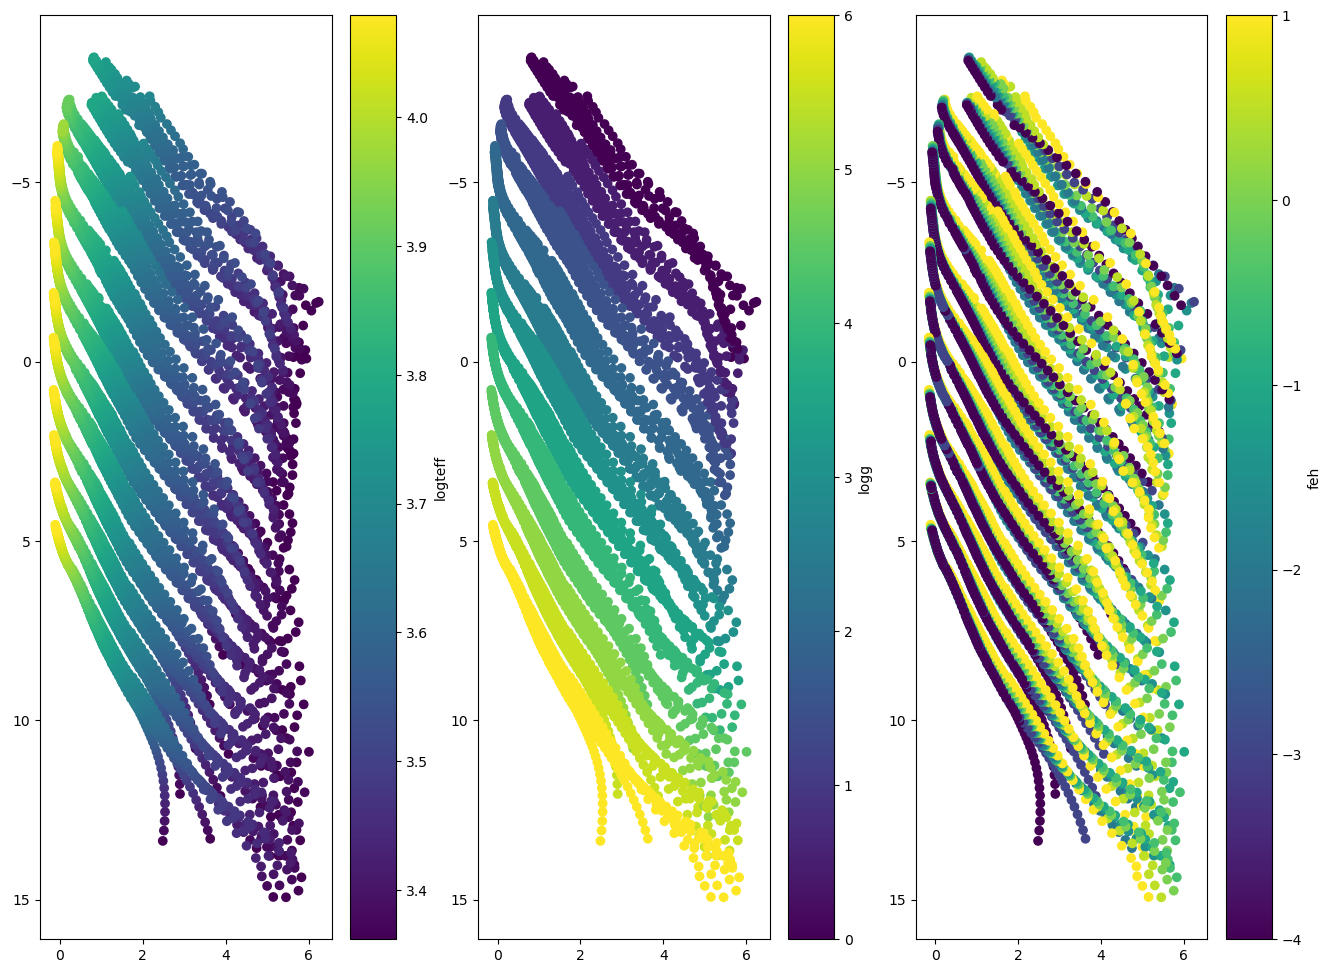

In [3]:
f814w = t['absmag_F814W_vega']
f475w = t['absmag_F475W_vega']

m = f814w
c = f475w - f814w

fig, axs = plt.subplots(1, 3, figsize=(16, 12))
for ax, nm in zip(axs.ravel(), 'logteff,logg,feh'.split(',')):
    plt.colorbar(ax.scatter(c, m, c=t[nm])).set_label(nm)
    ax.set_ylim(*ax.get_ylim()[::-1])

In [4]:
θ = torch.from_numpy(np.array([t['teff'], t['logg'], t['feh']]).T).to(torch.float32)
data = torch.from_numpy(np.array([c, m]).T).to(torch.float32)

In [7]:
inference = NPE(device='cuda')
inference.append_simulations(θ, data)

density_estimator = inference.train()

posterior = inference.build_posterior(density_estimator)

/home/erik/astro/phoenix/ml_generation/.pixi/envs/cuda/lib/python3.11/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Data x has device 'cpu'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/erik/astro/phoenix/ml_generation/.pixi/envs/cuda/lib/python3.11/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 133 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

array([[ 4.20172068e+03,  4.01112838e+00, -2.74433194e+00],
       [ 4.25491504e+03,  4.04233074e+00, -1.10327989e+00],
       [ 4.42816697e+03,  4.16459957e+00,  3.64789412e-01]])

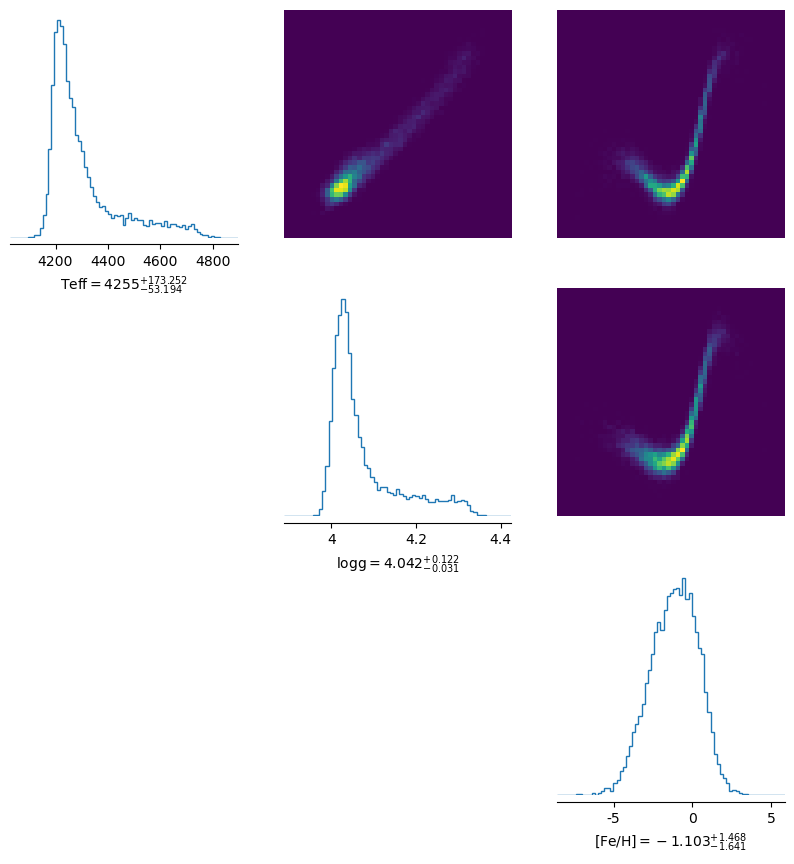

In [15]:
samples = posterior.sample((10000,), x=torch.Tensor((2, 5)).to('cuda')).cpu()

labels = []
for s, nm in zip(samples.T, ['Teff', 'logg', '[Fe/H]']):
    low, mid, up = np.quantile(s, [.158, .5, .841])
    plus = up - mid
    minus = mid - low
    numpart = f'{mid:.4g}^{{ + {plus:.3f} }}_{{ -{minus:.3f} }}'
    labels.append(r'${\rm ' + nm + '}=' + numpart + '$')

pairplot(samples, labels=labels)#=['Teff', 'logg', '[Fe/H]']);
np.quantile(samples, [.158, .5, .841], axis=0)

## Noisy data

In [16]:
munc = .1
cunc = .2

nunc = 50

caug = (c + cunc*np.random.randn(nunc).reshape(nunc, 1)).ravel()
maug = (m + munc*np.random.randn(nunc).reshape(nunc, 1)).ravel()

teff = (t['teff'] + np.zeros(nunc).reshape(nunc, 1)).ravel()
logg = (t['logg'] + np.zeros(nunc).reshape(nunc, 1)).ravel()
feh = (t['feh'] + np.zeros(nunc).reshape(nunc, 1)).ravel()

dataunc = torch.from_numpy(np.array([caug, maug]).T).to(torch.float32)
θunc = torch.from_numpy(np.array([teff, logg, feh]).T).to(torch.float32)

In [17]:
inference = NPE()
inference.append_simulations(θunc, dataunc)

density_estimator = inference.train()

posterior = inference.build_posterior(density_estimator)

/home/erik/astro/phoenix/ml_generation/.pixi/envs/cuda/lib/python3.11/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Data x has device 'cpu'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/erik/astro/phoenix/ml_generation/.pixi/envs/cuda/lib/python3.11/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Training neural network. Epochs trained: 4

KeyboardInterrupt: 

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

array([[ 4.14832441e+03,  3.99871283e+00, -2.84679468e+00],
       [ 4.30645825e+03,  4.00070333e+00, -9.99190927e-01],
       [ 4.56907351e+03,  4.16568731e+00,  4.39267620e-01]])

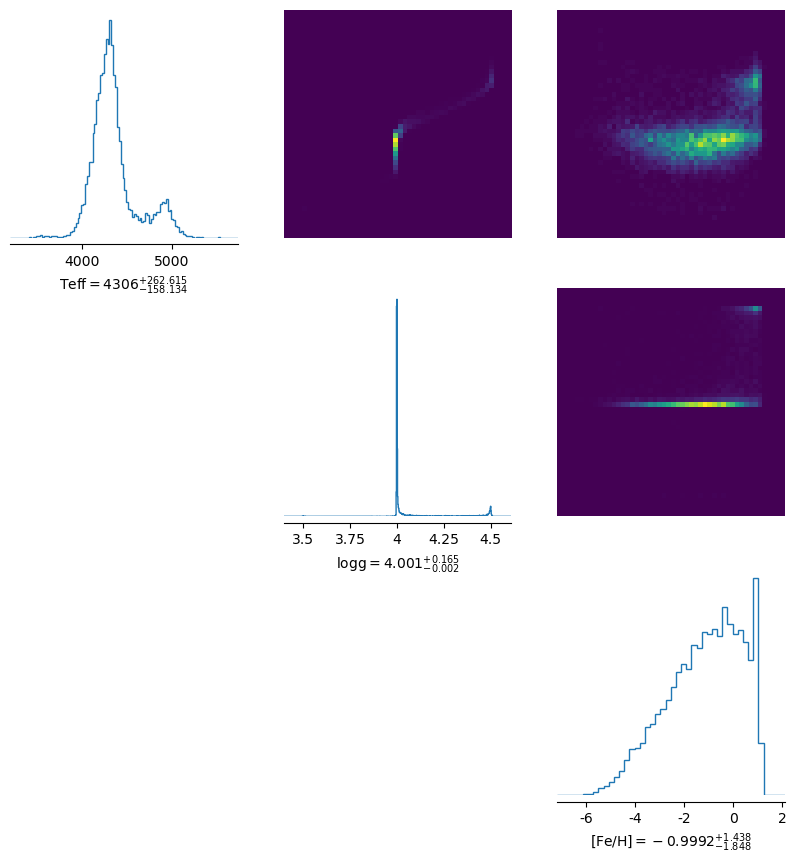

In [129]:
samples = posterior.sample((10000,), x=(2, 5))

labels = []
for s, nm in zip(samples.T, ['Teff', 'logg', '[Fe/H]']):
    low, mid, up = np.quantile(s, [.158, .5, .841])
    plus = up - mid
    minus = mid - low
    numpart = f'{mid:.4g}^{{ + {plus:.3f} }}_{{ -{minus:.3f} }}'
    labels.append(r'${\rm ' + nm + '}=' + numpart + '$')

pairplot(samples, labels=labels)#=['Teff', 'logg', '[Fe/H]']);
np.quantile(samples, [.158, .5, .841], axis=0)

A not too bad answer as it turns out, although the certianty in logg is a bit odd

# Restrict to an area around the observation

In [150]:
m0 = 5
c0 = 2

munc = .3
cunc = .6

nstdout = 3

nunc = 100

mmsk = np.abs((m - m0)/munc) < nstdout 
cmsk = np.abs((c - c0)/cunc) < nstdout 
msk = mmsk&cmsk

print('frac', np.sum(msk)/len(msk))

caug = (c[msk] + cunc*np.random.randn(nunc).reshape(nunc, 1)).ravel()
maug = (m[msk] + munc*np.random.randn(nunc).reshape(nunc, 1)).ravel()

teff = (t['teff'][msk] + np.zeros(nunc).reshape(nunc, 1)).ravel()
logg = (t['logg'][msk] + np.zeros(nunc).reshape(nunc, 1)).ravel()
feh = (t['feh'][msk] + np.zeros(nunc).reshape(nunc, 1)).ravel()

dataunc = torch.from_numpy(np.array([caug, maug]).T).to(torch.float32)
θunc = torch.from_numpy(np.array([teff, logg, feh]).T).to(torch.float32)

frac 0.08311134789557804


In [151]:
inference = NPE()
inference.append_simulations(θunc, dataunc)

density_estimator = inference.train()

posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 317 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

array([[ 3.72970601e+03,  3.50223069e+00, -2.99407810e+00],
       [ 4.47906616e+03,  4.00145173e+00, -1.01884419e+00],
       [ 5.56953178e+03,  4.50182844e+00,  4.78480620e-01]])

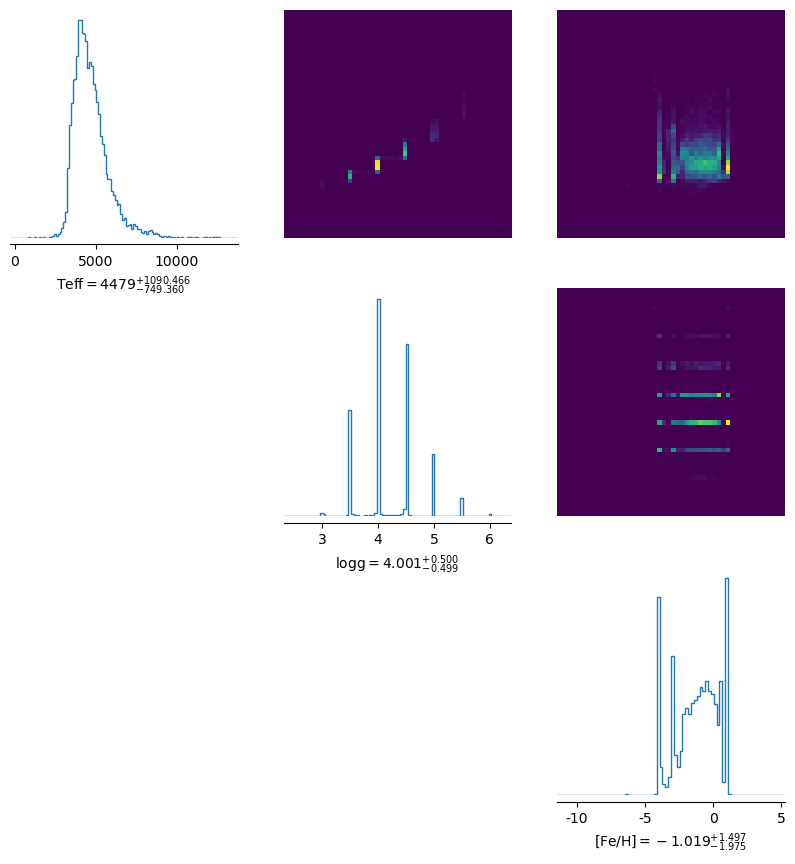

In [152]:
samples = posterior.sample((10000,), x=(c0, m0))

labels = []
for s, nm in zip(samples.T, ['Teff', 'logg', '[Fe/H]']):
    low, mid, up = np.quantile(s, [.158, .5, .841])
    plus = up - mid
    minus = mid - low
    numpart = f'{mid:.4g}^{{ + {plus:.3f} }}_{{ -{minus:.3f} }}'
    labels.append(r'${\rm ' + nm + '}=' + numpart + '$')

pairplot(samples, labels=labels)#=['Teff', 'logg', '[Fe/H]']);
np.quantile(samples, [.158, .5, .841], axis=0)

Hmm, it's clearly failing to interpolate well over the feh and logg grids...